<a href="https://colab.research.google.com/github/aleksl17/IKT440ptmc/blob/colab/TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

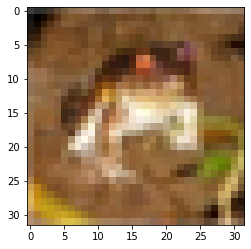

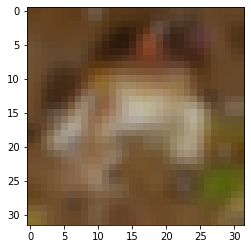


Accuracy over 50 epochs:

#1 Accuracy: 36.99%/37.98% Training: 132.24s Testing: 151.15s
#2 Accuracy: 43.16%/44.44% Training: 117.28s Testing: 149.60s
#3 Accuracy: 45.15%/45.65% Training: 117.21s Testing: 148.33s
#4 Accuracy: 47.58%/47.36% Training: 115.22s Testing: 147.21s
#5 Accuracy: 48.96%/48.30% Training: 114.84s Testing: 146.65s
#6 Accuracy: 49.32%/48.07% Training: 113.83s Testing: 146.28s
#7 Accuracy: 52.27%/50.65% Training: 113.58s Testing: 145.74s
#8 Accuracy: 50.13%/47.96% Training: 113.12s Testing: 145.61s
#9 Accuracy: 42.56%/43.19% Training: 112.46s Testing: 144.57s
#10 Accuracy: 54.35%/52.38% Training: 112.22s Testing: 144.12s
#11 Accuracy: 50.58%/47.72% Training: 111.97s Testing: 145.33s
#12 Accuracy: 45.72%/45.40% Training: 111.84s Testing: 144.25s
#13 Accuracy: 54.33%/51.39% Training: 111.42s Testing: 143.66s
#14 Accuracy: 48.72%/47.16% Training: 111.22s Testing: 143.72s
#15 Accuracy: 46.85%/45.34% Training: 110.76s Testing: 142.59s
#16 Accuracy: 52.18%/48.78% Training:

In [ ]:
!pip3 install pycuda
!pip3 install pyTsetlinMachineCUDA
!pip3 install opencv-python

from PyTsetlinMachineCUDA.tm import MultiClassConvolutionalTsetlinMachine2D
#import sys
#sys.path.append('../pyTsetlinMachine/')
#from tm import MultiClassConvolutionalTsetlinMachine2D
import numpy as np
from time import time
import copy
import matplotlib.pyplot as plt
import math
import imgaug


from keras.datasets import cifar10

import cv2

factor = 1
clauses = 4000*factor
T = 75*100*factor
s = 10.0
patch = 8
img_size = 32

epochs = 50

labels = [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']

tm = MultiClassConvolutionalTsetlinMachine2D(clauses, T, s, (patch, patch), number_of_state_bits=8, max_weight=255)
#tm = MultiClassConvolutionalTsetlinMachine2D(clauses, T, s, (patch, patch), weighted_clauses=True)

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

#do augmentation here
# Global Variables
augmentation_percentage = 30

# Import and manipulate dataset
a_p = math.floor((augmentation_percentage / 100) * len(X_train))
x_train_aug_before = copy.deepcopy(X_train[0:a_p])
x_train_aug_before = x_train_aug_before.astype("float32")

# Augmentation variables
seq = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(rotate=(-25, 25)),
    imgaug.augmenters.SaltAndPepper(p=(0, 0.1)),
    imgaug.augmenters.Crop(percent=(0, 0.25))
])

# Image augmentation
x_aug = seq.augment_images(x_train_aug_before)
y_aug = Y_train[0:a_p]

#do adaptive gaussian filtering here

def gaussian_kernel(size, sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

gaussian_images = []

for img in x_aug:
  new_img = cv2.filter2D(img, -1, gaussian_kernel(2,sigma=1))
  gaussian_images.append(new_img)

gaussian_images = np.array(gaussian_images)
gaussian_images = gaussian_images.astype(int)

plt.imshow(X_train[0])
plt.show()

plt.imshow(gaussian_images[0])
plt.show()


#append augmented images to training data
X_train = np.concatenate((X_train, gaussian_images), axis=0)
Y_train = np.concatenate((Y_train, y_aug),axis=0)

#convert X to uint8
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)

#reshape dataset
Y_train=Y_train.reshape(Y_train.shape[0])
Y_test=Y_test.reshape(Y_test.shape[0])

for i in range(X_train.shape[0]):
        for j in range(X_train.shape[3]):
                X_train[i,:,:,j] = cv2.adaptiveThreshold(X_train[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2) #cv2.adaptiveThreshold(X_train[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 5)

for i in range(X_test.shape[0]):
        for j in range(X_test.shape[3]):
                X_test[i,:,:,j] = cv2.adaptiveThreshold(X_test[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)#cv2.adaptiveThreshold(X_test[i,:,:,j], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 5)


accuracy_history = []

print("\nAccuracy over %d epochs:\n" % epochs)
for i in range(epochs):
        start_training = time()
        tm.fit(X_train, Y_train, epochs=1, incremental=True)
        stop_training = time()

        start_testing = time()
        result_test = 100*(tm.predict(X_test) == Y_test).mean()
        accuracy_history.append(result_test)
        result_train= 100*(tm.predict(X_train) == Y_train).mean()
        stop_testing = time()

        print("#%d Accuracy: %.2f%%/%.2f%% Training: %.2fs Testing: %.2fs" % (i+1, result_train, result_test, stop_training-start_training, stop_testing-start_testing))


plt.plot(accuracy_history)
plt.show()

#testing

pred = tm.predict(X_test)

correct = 0
fail = 0
for i in range(len(X_test)):
  if pred[i] == Y_test[i]:
    correct += 1
  else:
    fail += 1

print("Testing Accuracy after "+ str(epochs) +" epochs:")
print(str(correct/(correct+fail)))

